In [1]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, kruskal, mannwhitneyu
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

In [3]:
cluster_path = Path('/Users/tonizeng/Desktop/ibd_trajectory_project/results/dual_encoder_model/clustering_results.pkl')
with open(cluster_path, 'rb') as f:
    clustering = pickle.load(f)

data_path = Path('/Users/tonizeng/Desktop/ibd_trajectory_project/data/processed/multimodal_unaligned_data.pkl')
with open(data_path, 'rb') as f:
    data = pickle.load(f)

patients = data['patients']

print("Data loaded successfully")
print(f"CD: K={clustering['CD']['K']}, sizes: {np.bincount(clustering['CD']['labels_gmm'])}")
print(f"UC: K={clustering['UC']['K']}, sizes: {np.bincount(clustering['UC']['labels_gmm'])}")

Data loaded successfully
CD: K=3, sizes: [ 4 16 21]
UC: K=2, sizes: [11 11]


## MTX signal extraction per patient

In [4]:
def get_patient_mtx_stats(patient_id, patient_dict):
    """Get MTX inflammatory statistics for one patient."""
    if patient_id not in patient_dict:
        return None
    
    patient_data = patient_dict[patient_id]
    mtx_coords = patient_data['mtx']['pca_coords']
    
    inflammatory_signal = np.linalg.norm(mtx_coords, axis=1)
    
    mtx_stats = {
        'mean_inflammation': np.mean(inflammatory_signal),
        'max_inflammation': np.max(inflammatory_signal),
        'std_inflammation': np.std(inflammatory_signal),
        'inflammation_trend': inflammatory_signal[-1] - inflammatory_signal[0] if len(inflammatory_signal) > 1 else 0,
        'n_timepoints': len(inflammatory_signal)
    }
    
    return mtx_stats

def extract_mtx_by_subtype(patient_ids, labels, patient_dict):
    """Organize MTX stats by subtype."""
    subtype_data = {}
    
    for patient_id, label in zip(patient_ids, labels):
        if label not in subtype_data:
            subtype_data[label] = []
        
        mtx_stats = get_patient_mtx_stats(patient_id, patient_dict)
        if mtx_stats is not None:
            subtype_data[label].append({
                'patient_id': patient_id,
                **mtx_stats
            })
    
    return subtype_data

cd_mtx = extract_mtx_by_subtype(clustering['CD']['patient_ids'], clustering['CD']['labels_gmm'], patients)
uc_mtx = extract_mtx_by_subtype(clustering['UC']['patient_ids'], clustering['UC']['labels_gmm'], patients)

print("\nCD MTX data by subtype:")
for label, data_list in cd_mtx.items():
    print(f"  Subtype {label}: {len(data_list)} patients")

print("\nUC MTX data by subtype:")
for label, data_list in uc_mtx.items():
    print(f"  Subtype {label}: {len(data_list)} patients")


CD MTX data by subtype:
  Subtype 0: 4 patients
  Subtype 1: 16 patients
  Subtype 2: 21 patients

UC MTX data by subtype:
  Subtype 0: 11 patients
  Subtype 1: 11 patients


## test subtype differences

In [5]:
def test_subtype_differences(subtype_data, metric='mean_inflammation'):
    """Statistical test for subtype differences."""
    groups = []
    labels = []
    
    for label, data_list in sorted(subtype_data.items()):
        values = [d[metric] for d in data_list]
        groups.append(values)
        labels.append(label)
    
    # ANOVA / Kruskal-Wallis
    if len(groups) > 2:
        f_stat, p_anova = f_oneway(*groups)
        h_stat, p_kruskal = kruskal(*groups)
        test_name = 'ANOVA / Kruskal-Wallis'
    else:
        u_stat, p_anova = mannwhitneyu(groups[0], groups[1])
        p_kruskal = p_anova
        test_name = 'Mann-Whitney U'
    
    means = [np.mean(g) for g in groups]
    stds = [np.std(g) for g in groups]
    
    return {
        'test': test_name,
        'p_value': p_anova,
        'p_kruskal': p_kruskal,
        'means': means,
        'stds': stds,
        'labels': labels,
        'groups': groups
    }

print("=" * 70)
print("MTX VALIDATION: Do subtypes differ in inflammatory signal?")
print("=" * 70)

print("\nCD Subtypes:")
cd_test = test_subtype_differences(cd_mtx, 'mean_inflammation')
print(f"  Test: {cd_test['test']}")
print(f"  p-value (ANOVA): {cd_test['p_value']:.4f}")
print(f"  p-value (Kruskal): {cd_test['p_kruskal']:.4f}")
for label, mean, std in zip(cd_test['labels'], cd_test['means'], cd_test['stds']):
    print(f"    Subtype {label}: {mean:.3f} ± {std:.3f}")

print("\nUC Subtypes:")
uc_test = test_subtype_differences(uc_mtx, 'mean_inflammation')
print(f"  Test: {uc_test['test']}")
print(f"  p-value: {uc_test['p_value']:.4f}")
for label, mean, std in zip(uc_test['labels'], uc_test['means'], uc_test['stds']):
    print(f"    Subtype {label}: {mean:.3f} ± {std:.3f}")

MTX VALIDATION: Do subtypes differ in inflammatory signal?

CD Subtypes:
  Test: ANOVA / Kruskal-Wallis
  p-value (ANOVA): 0.0017
  p-value (Kruskal): 0.0209
    Subtype 0: 29.396 ± 6.093
    Subtype 1: 20.699 ± 2.654
    Subtype 2: 22.212 ± 4.070

UC Subtypes:
  Test: Mann-Whitney U
  p-value: 0.6458
    Subtype 0: 20.560 ± 2.364
    Subtype 1: 21.174 ± 2.700


In [6]:
print("\n" + "=" * 70)
print("MTX CHANGE PATTERNS: Do subtypes differ in inflammation trajectory?")
print("=" * 70)

print("\nCD Subtypes (inflammation trend):")
cd_trend_test = test_subtype_differences(cd_mtx, 'inflammation_trend')
print(f"  p-value: {cd_trend_test['p_value']:.4f}")
for label, mean, std in zip(cd_trend_test['labels'], cd_trend_test['means'], cd_trend_test['stds']):
    direction = "increasing" if mean > 0 else "decreasing"
    print(f"    Subtype {label}: {mean:.3f} ± {std:.3f} ({direction})")

print("\nUC Subtypes (inflammation trend):")
uc_trend_test = test_subtype_differences(uc_mtx, 'inflammation_trend')
print(f"  p-value: {uc_trend_test['p_value']:.4f}")
for label, mean, std in zip(uc_trend_test['labels'], uc_trend_test['means'], uc_trend_test['stds']):
    direction = "increasing" if mean > 0 else "decreasing"
    print(f"    Subtype {label}: {mean:.3f} ± {std:.3f} ({direction})")


MTX CHANGE PATTERNS: Do subtypes differ in inflammation trajectory?

CD Subtypes (inflammation trend):
  p-value: 0.7408
    Subtype 0: 2.226 ± 8.336 (increasing)
    Subtype 1: -0.012 ± 5.883 (decreasing)
    Subtype 2: -0.188 ± 4.496 (decreasing)

UC Subtypes (inflammation trend):
  p-value: 0.6458
    Subtype 0: -1.215 ± 5.795 (decreasing)
    Subtype 1: -2.257 ± 6.229 (decreasing)


## visualization

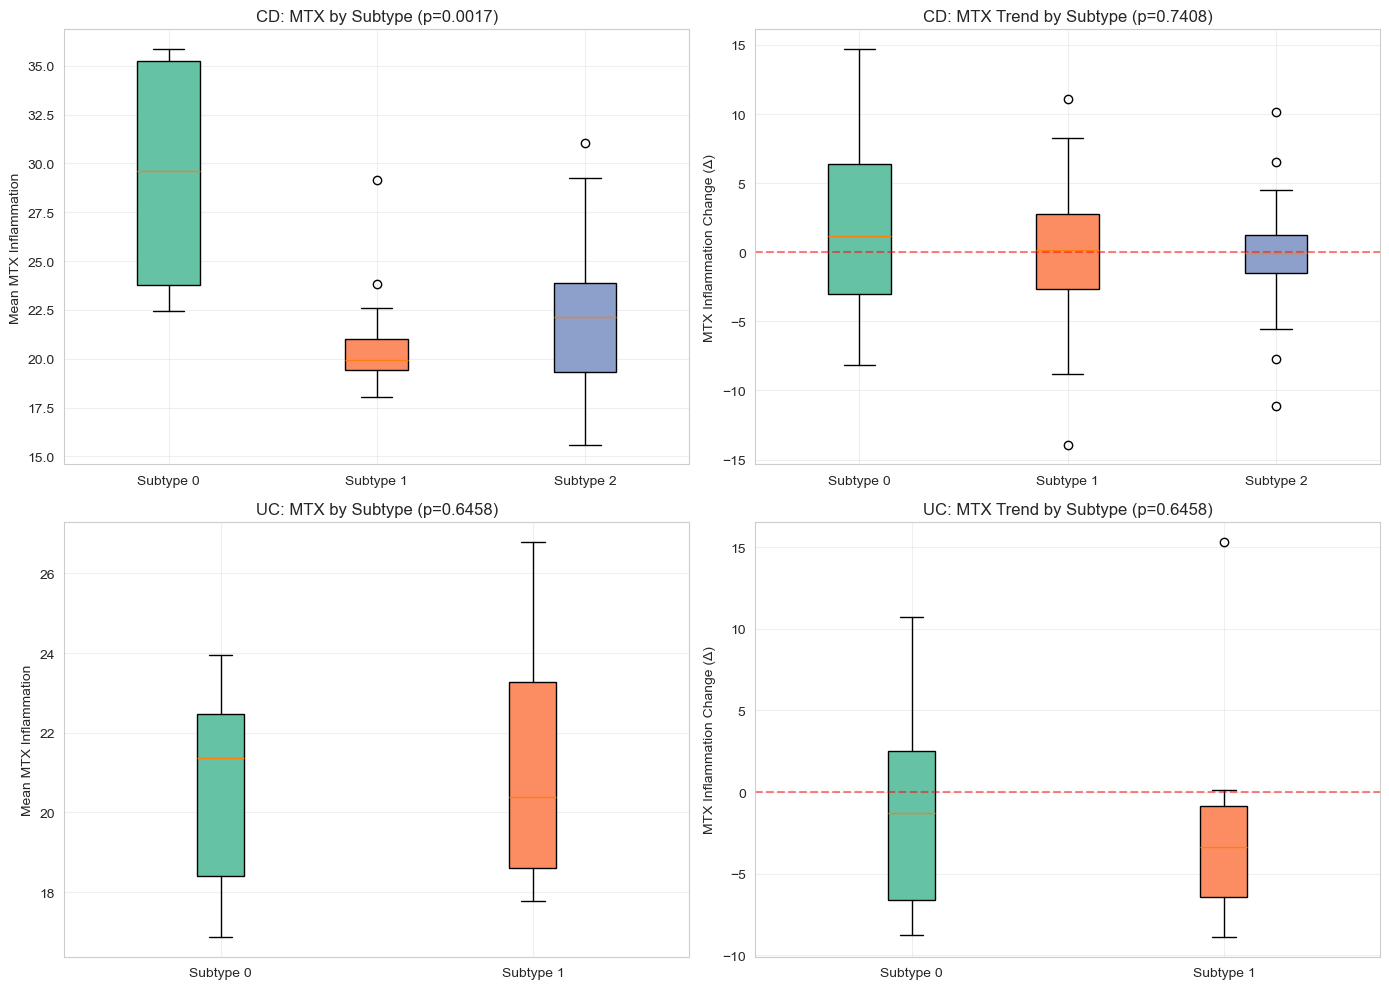

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# CD mean inflammation
ax = axes[0, 0]
cd_data = []
cd_labels = []
for label in sorted(cd_mtx.keys()):
    values = [d['mean_inflammation'] for d in cd_mtx[label]]
    cd_data.append(values)
    cd_labels.append(f'Subtype {label}')

bp = ax.boxplot(cd_data, labels=cd_labels, patch_artist=True)
for patch, color in zip(bp['boxes'], sns.color_palette('Set2', len(cd_labels))):
    patch.set_facecolor(color)
ax.set_ylabel('Mean MTX Inflammation')
ax.set_title(f'CD: MTX by Subtype (p={cd_test["p_value"]:.4f})')
ax.grid(alpha=0.3)

# CD inflammation trend
ax = axes[0, 1]
cd_trend_data = []
for label in sorted(cd_mtx.keys()):
    values = [d['inflammation_trend'] for d in cd_mtx[label]]
    cd_trend_data.append(values)

bp = ax.boxplot(cd_trend_data, labels=cd_labels, patch_artist=True)
for patch, color in zip(bp['boxes'], sns.color_palette('Set2', len(cd_labels))):
    patch.set_facecolor(color)
ax.axhline(0, color='red', linestyle='--', alpha=0.5)
ax.set_ylabel('MTX Inflammation Change (Δ)')
ax.set_title(f'CD: MTX Trend by Subtype (p={cd_trend_test["p_value"]:.4f})')
ax.grid(alpha=0.3)

# UC mean inflammation
ax = axes[1, 0]
uc_data = []
uc_labels = []
for label in sorted(uc_mtx.keys()):
    values = [d['mean_inflammation'] for d in uc_mtx[label]]
    uc_data.append(values)
    uc_labels.append(f'Subtype {label}')

bp = ax.boxplot(uc_data, labels=uc_labels, patch_artist=True)
for patch, color in zip(bp['boxes'], sns.color_palette('Set2', len(uc_labels))):
    patch.set_facecolor(color)
ax.set_ylabel('Mean MTX Inflammation')
ax.set_title(f'UC: MTX by Subtype (p={uc_test["p_value"]:.4f})')
ax.grid(alpha=0.3)

# UC inflammation trend
ax = axes[1, 1]
uc_trend_data = []
for label in sorted(uc_mtx.keys()):
    values = [d['inflammation_trend'] for d in uc_mtx[label]]
    uc_trend_data.append(values)

bp = ax.boxplot(uc_trend_data, labels=uc_labels, patch_artist=True)
for patch, color in zip(bp['boxes'], sns.color_palette('Set2', len(uc_labels))):
    patch.set_facecolor(color)
ax.axhline(0, color='red', linestyle='--', alpha=0.5)
ax.set_ylabel('MTX Inflammation Change (Δ)')
ax.set_title(f'UC: MTX Trend by Subtype (p={uc_trend_test["p_value"]:.4f})')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/dual_encoder_model/subtype_mtx_validation.png', dpi=150)
plt.show()

## clinical score validation 

In [8]:
def get_patient_clinical_stats(patient_id, patient_dict):
    """Get clinical score statistics for one patient."""
    if patient_id not in patient_dict:
        return None
    
    patient_data = patient_dict[patient_id]
    scores = patient_data['mgx']['disease_activity']
    
    valid_scores = scores[~np.isnan(scores)]
    if len(valid_scores) == 0:
        return None
    
    return {
        'mean_score': np.mean(valid_scores),
        'max_score': np.max(valid_scores),
        'std_score': np.std(valid_scores)
    }

def extract_clinical_by_subtype(patient_ids, labels, patient_dict):
    """Organize clinical scores by subtype."""
    subtype_data = {}
    
    for patient_id, label in zip(patient_ids, labels):
        if label not in subtype_data:
            subtype_data[label] = []
        
        clinical_stats = get_patient_clinical_stats(patient_id, patient_dict)
        if clinical_stats is not None:
            subtype_data[label].append(clinical_stats)
    
    return subtype_data

cd_clinical = extract_clinical_by_subtype(clustering['CD']['patient_ids'], clustering['CD']['labels_gmm'], patients)
uc_clinical = extract_clinical_by_subtype(clustering['UC']['patient_ids'], clustering['UC']['labels_gmm'], patients)

print("\n" + "=" * 70)
print("CLINICAL VALIDATION: Do subtypes differ in disease activity?")
print("=" * 70)

print("\nCD Subtypes (HBI):")
cd_clinical_test = test_subtype_differences(cd_clinical, 'mean_score')
print(f"  p-value: {cd_clinical_test['p_value']:.4f}")
for label, mean, std in zip(cd_clinical_test['labels'], cd_clinical_test['means'], cd_clinical_test['stds']):
    print(f"    Subtype {label}: {mean:.3f} ± {std:.3f}")

print("\nUC Subtypes (SCCAI):")
uc_clinical_test = test_subtype_differences(uc_clinical, 'mean_score')
print(f"  p-value: {uc_clinical_test['p_value']:.4f}")
for label, mean, std in zip(uc_clinical_test['labels'], uc_clinical_test['means'], uc_clinical_test['stds']):
    print(f"    Subtype {label}: {mean:.3f} ± {std:.3f}")


CLINICAL VALIDATION: Do subtypes differ in disease activity?

CD Subtypes (HBI):
  p-value: 0.4196
    Subtype 0: 3.402 ± 1.739
    Subtype 1: 2.512 ± 1.821
    Subtype 2: 2.162 ± 1.544

UC Subtypes (SCCAI):
  p-value: 0.5544
    Subtype 0: 1.938 ± 0.811
    Subtype 1: 2.871 ± 2.110


## bootstrap stability test 

In [9]:
from sklearn.metrics import adjusted_rand_score
from sklearn.mixture import GaussianMixture

def bootstrap_stability(features, K, n_bootstrap=50):
    """Test clustering stability via bootstrap."""
    n_samples = len(features)
    ari_scores = []
    
    # Fit on full data
    gmm_full = GaussianMixture(n_components=K, random_state=42, n_init=10)
    labels_full = gmm_full.fit_predict(features)
    
    for i in range(n_bootstrap):
        # Bootstrap sample
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        features_boot = features[indices]
        
        # Fit on bootstrap
        gmm_boot = GaussianMixture(n_components=K, random_state=i, n_init=10)
        labels_boot = gmm_boot.fit_predict(features)
        
        # Compare to full
        ari = adjusted_rand_score(labels_full, labels_boot)
        ari_scores.append(ari)
    
    return np.mean(ari_scores), np.std(ari_scores)

print("\n" + "=" * 70)
print("STABILITY ANALYSIS: Bootstrap ARI")
print("=" * 70)

print("\nCD Clustering Stability:")
cd_ari_mean, cd_ari_std = bootstrap_stability(clustering['CD']['features_scaled'], clustering['CD']['K'])
print(f"  Bootstrap ARI: {cd_ari_mean:.3f} ± {cd_ari_std:.3f}")
print(f"  Interpretation: {'STABLE' if cd_ari_mean > 0.7 else 'MODERATE' if cd_ari_mean > 0.5 else 'UNSTABLE'}")

print("\nUC Clustering Stability:")
uc_ari_mean, uc_ari_std = bootstrap_stability(clustering['UC']['features_scaled'], clustering['UC']['K'])
print(f"  Bootstrap ARI: {uc_ari_mean:.3f} ± {uc_ari_std:.3f}")
print(f"  Interpretation: {'STABLE' if uc_ari_mean > 0.7 else 'MODERATE' if uc_ari_mean > 0.5 else 'UNSTABLE'}")


STABILITY ANALYSIS: Bootstrap ARI

CD Clustering Stability:
  Bootstrap ARI: 0.717 ± 0.249
  Interpretation: STABLE

UC Clustering Stability:
  Bootstrap ARI: 0.773 ± 0.385
  Interpretation: STABLE


## 8. Summary Report

In [11]:
print("\n" + "=" * 70)
print("SUBTYPE DISCOVERY SUMMARY")
print("=" * 70)

print("\n**CD SUBTYPES:**")
print(f"  Number of subtypes: {clustering['CD']['K']}")
print(f"  Cluster sizes: {np.bincount(clustering['CD']['labels_gmm'])}")
print(f"  MTX validation: p={cd_test['p_value']:.4f} {'(SIGNIFICANT)' if cd_test['p_value'] < 0.05 else '(not significant)'}")
print(f"  Clinical validation: p={cd_clinical_test['p_value']:.4f} {'(SIGNIFICANT)' if cd_clinical_test['p_value'] < 0.05 else '(not significant)'}")
print(f"  Stability (ARI): {cd_ari_mean:.3f} ({'STABLE' if cd_ari_mean > 0.7 else 'MODERATE' if cd_ari_mean > 0.5 else 'UNSTABLE'})")

print("\n**UC SUBTYPES:**")
print(f"  Number of subtypes: {clustering['UC']['K']}")
print(f"  Cluster sizes: {np.bincount(clustering['UC']['labels_gmm'])}")
print(f"  MTX validation: p={uc_test['p_value']:.4f} {'(SIGNIFICANT)' if uc_test['p_value'] < 0.05 else '(not significant)'}")
print(f"  Clinical validation: p={uc_clinical_test['p_value']:.4f} {'(SIGNIFICANT)' if uc_clinical_test['p_value'] < 0.05 else '(not significant)'}")
print(f"  Stability (ARI): {uc_ari_mean:.3f} ({'STABLE' if uc_ari_mean > 0.7 else 'MODERATE' if uc_ari_mean > 0.5 else 'UNSTABLE'})")


SUBTYPE DISCOVERY SUMMARY

**CD SUBTYPES:**
  Number of subtypes: 3
  Cluster sizes: [ 4 16 21]
  MTX validation: p=0.0017 (SIGNIFICANT)
  Clinical validation: p=0.4196 (not significant)
  Stability (ARI): 0.717 (STABLE)

**UC SUBTYPES:**
  Number of subtypes: 2
  Cluster sizes: [11 11]
  MTX validation: p=0.6458 (not significant)
  Clinical validation: p=0.5544 (not significant)
  Stability (ARI): 0.773 (STABLE)
